In [1]:
# %matplotlib widget

import sys
import os
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.constants import c
from astropy import units as u
from PyAstronomy import pyasl
from lmfit import Minimizer, Parameters

import seaborn as sns

sns.set(context="talk", style="ticks", palette="husl", color_codes=True)

In [2]:
SIM_NAME = "DIG_bright"
EXP_TIME = 900

SIM_PATH = f"../simulations/_data-sim/{SIM_NAME}/outputs"

SIMPLE_SIM_NAME = f"{SIM_NAME}_linear_full_{EXP_TIME}_flux.fits"

current_sim = SIMPLE_SIM_NAME

In [3]:
f = fits.open(os.path.join(SIM_PATH, current_sim))

id_ = 350
z_true = 0.00
wl__w, f__w = f["WAVE"].data*(1+z_true), f["TARGET"].data[id_]
ef__w = f["ERR"].data[id_]
# fnorm = np.abs(f__w[f__w.size//2])
# fnorm = np.max(f__w)
# f__w = f__w / fnorm
# ef__w = ef__w / fnorm

In [4]:
# procedure:
# - perform gaussian fitting using input redshift
# - define template for CCF using as input the best fitting parameters in the previous fit
# - perform CC fitting to find maximum cross correlation location
# - refine search of cross correlation in a range centered at the maximum
# - calculate bisectors
# - perform fitting of the systemic velocity and the LOSVD in the velocity space
# 
# refactor:
# 1. define parameters dictionary:
# {model: 
# 	[
# 		{par_1: 'X', value: x, min: xmin, max: xmax, expr: 'f(X)'},
# 		{par_2:...},
# 		...
# 		{par_n:...}
# 	]
# }
# 
# 2. define base models dictionary:
# MODELS = {'gaussian': gauss_model, 'voigt': voigt_model}
# 
# 3. define parameters object with all parameters and ligatures
# 
# 4. define joint model: the summation of all individual models
# 
# 5. define minimizer
# 
# 6. perform minimization
# 
# 7. evaluate best model
# 
# 8. extract physical properties

In [9]:
from functools import partial


def gaussian_model(pars, id, wave, common_pars):
    w = pars["wl"] if "wl" in common_pars else pars[f"wl{id}"]
    A = pars["A"] if "A" in common_pars else pars[f"A{id}"]
    z = pars["z"] if "z" in common_pars else pars[f"z{id}"]
    s = pars["sigma"] if "sigma" in common_pars else pars[f"sigma{id}"]
    model = A * np.exp(-0.5*(wave - w * (z+1))**2 / s**2)
    return model

def residuals(pars, models_fcn, common_pars, wave, flux, error):
    n_models = len(models_fcn)
    model = np.zeros_like(wave)
    for i_mod in range(n_models):
        model += models_fcn[i_mod](pars, id=i_mod, wave=wave, common_pars=common_pars)
    
    # add constant if present, else add zero
    model += pars.get("constant", 0.0)

    return (model - flux) / error

# TODO: make this model agnostic to the emission line profile
# in other words, make a function for a gaussian profile and one for other profiles (e.g., voigt)
def sigma_CCF(pars, vel, flux):
	model = pars["A_ccf"] * np.exp(-0.5*(vel - pars["v_ccf"])**2 / (pars["sigma_ccf"]**2))
	return model - flux

def ccf_analysis(wave, flux, error, params, models, common_pars, cont_hw=80, cc_hw=700, plot=True):

    # define eline wavelengths in rest frame
    l0, l1, l2 = params["wl0"], params["wl1"], params["wl2"]

    # define min/max wavelengths for the fit in rest frame
    waves = [l0, l1, l2]
    min_w = np.nanmin(waves)
    max_w = np.nanmax(waves)

    # define wavelength positions for the fitting
    idx_fit = np.where((wave>(min_w*(params["z"]+1)-cont_hw)) & (wave<(max_w*(params["z"]+1)+cont_hw)))

    #wave range to estimate CCF
    wave_range = wave[idx_fit]
    flux_range = flux[idx_fit]
    error_range = error[idx_fit]
    #Normalize the flux to the maximum value
    max_flux = np.nanmax(flux_range)
    flux_range = flux_range / max_flux
    error_range = error_range / max_flux

    #A guess of SN
    SN = np.median(flux_range[:cont_hw] / error_range[:cont_hw])

    if np.isfinite(SN):
        mini = Minimizer(userfcn=residuals, params=params, fcn_args=(models, common_pars, wave_range, flux_range, error_range))
        param_fit = mini.minimize(method="powell")

        ini_model = residuals(params, models_fcn=models, common_pars=common_pars, wave=wave_range, flux=0.0, error=1.0)
        fin_model = residuals(param_fit.params, models_fcn=models, common_pars=common_pars, wave=wave_range, flux=0.0, error=1.0)

        if plot:
            plt.figure(figsize=(5,7))
            plt.step(wave_range, flux_range, color="0.2", label="input spectrum")
            plt.step(wave_range, ini_model, color="0.7", label="initial model")
            plt.step(wave_range, fin_model, color="b", label="parametric fit")
            plt.xlabel("wavelength (AA)")
            plt.ylabel("normalized flux")
            plt.legend(loc=2, frameon=False, fontsize="xx-small")
            plt.show()

        # Create the template
        ccf_wave = np.linspace(min_w*(1+param_fit.params["z"])-2*cont_hw,max_w*(1+param_fit.params["z"])+2*cont_hw,1000)
        ccf_model = partial(residuals, pars=param_fit.params, models_fcn=models, common_pars=common_pars, flux=0.0, error=1.0)
        
        # Carry out the cross-correlation.
        # The RV-range is -700 - +700 km/s in steps of 1 km/s.

        rv, cc = pyasl.crosscorrRV(wave_range, flux_range, ccf_wave, ccf_model(wave=ccf_wave), -cc_hw, cc_hw, 1)
        # Find the index of maximum cross-correlation function
        maxind = np.argmax(cc)
        v_peak = rv[maxind]

        #CALCULATE AGAIN THE CCF, but centered in the peak
        rv, cc = pyasl.crosscorrRV(wave_range, flux_range, ccf_wave, ccf_model(wave=ccf_wave), v_peak-cc_hw/2, v_peak+cc_hw/2, 1)
        # normalize CC
        cc = cc - np.nanmin(cc)
        cc = cc / np.nanmax(cc)

        #Calculate the bisectors
        x_bis = []
        y_bis = []
        delta_v = []
        for i in np.arange(0,0.9,0.1):
            li = (0.9-i)
            ls = (1-i)
            index = np.where((cc>li) & (cc<=ls))
            vels = np.mean(rv[index])
            x_bis.append(vels)
            y_bis.append(li)
            delta_v.append(vels-v_peak)
        abs_delta_v = np.abs(delta_v)

        #SAVE CCF and BISECTORS
        MEAN = np.nanmean(abs_delta_v)
        MEDIAN = np.nanmedian(abs_delta_v)
        BISECTOR = delta_v

        # PERFORM A QUICK FIT TO ESTIMATE VELOCITY AND SIGMA
        # create a set of Parameters
        # TODO: make this an input parameter, so that we have parametric and CCF parameters
        params = Parameters()
        params.add('sigma_ccf', value=param_fit.params["sigma"])
        params.add('A_ccf', value=1)
        params.add('v_ccf', value=0)

        # do fit, here with leastsq model
        # TODO: make 'sigma_CCF' an input parameter
        minner = Minimizer(sigma_CCF, params, fcn_args=(rv,cc))
        ccf_fit = minner.minimize()

        if plot:
            plt.figure(figsize=(20,5))
            plt.subplot(121)
            plt.step(wave_range, flux_range, color="0.2")
            plt.step(ccf_wave, ccf_model(wave=ccf_wave), color="r")
            plt.xlabel("wavelength (AA)")
            plt.ylabel("normalized flux")
            plt.subplot(122)
            plt.step(rv, cc,"-", color="0.5", label="velocity profile")
            plt.step(x_bis, y_bis,"bx", label="barycenter")
            plt.xlabel("velocity (km/s)")
            plt.ylabel("CCF")
            plt.legend(loc=0, frameon=False, fontsize="xx-small")
            plt.show()

        return param_fit, ccf_fit, MEAN, MEDIAN, BISECTOR

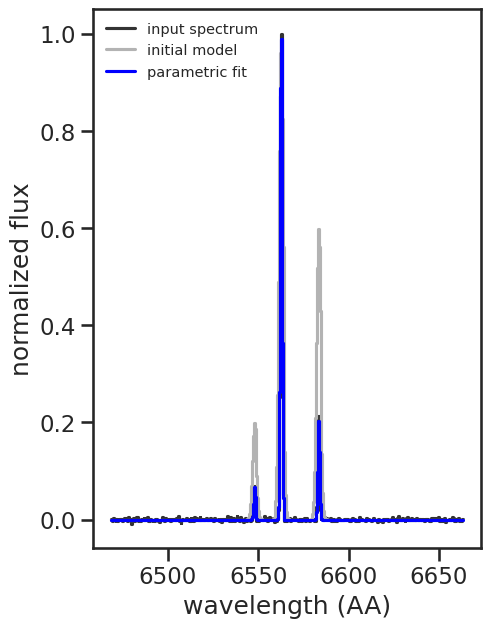

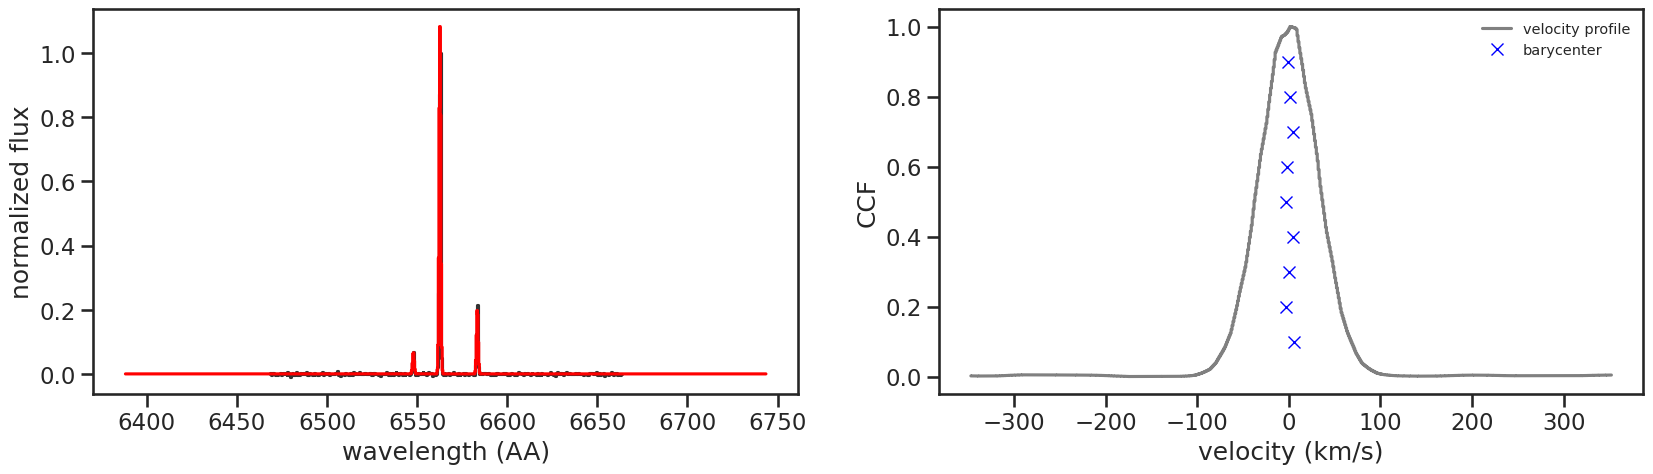

In [10]:
z = 0.00
vel_hw = 1500
speed_light = c.to(u.km / u.s).value
z_hw = vel_hw / speed_light

params = Parameters()
params.add("wl0", value=6548.1001, vary=False)
params.add("wl1", value=6562.8169, vary=False)
params.add("wl2", value=6583.6001, vary=False)

params.add("A1", value=1.0, min=0.0)
params.add("A2", value=0.6, min=0.0)
params.add("A0", value=0.2, min=0.0, expr="A2 / 3")

params.add("z", value=z, min=z-z_hw, max=z+z_hw)
params.add("sigma", value=1.1, min=1e-5)

params.add("constant", value=0)

par_fit, ccf_fit, mean, median, bisec = ccf_analysis(wave=wl__w, flux=f__w, error=ef__w, params=params, models=(gaussian_model, gaussian_model, gaussian_model), common_pars=("z", "sigma"))


In [11]:
par_fit

In [12]:
ccf_fit